In [492]:
import glob
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from sklearn import preprocessing
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from random import randint
import joblib


In [493]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [494]:
import os
from dotenv import load_dotenv
load_dotenv()
print(os.getenv('ROOT'))

import sys
sys.path.append(os.getenv('ROOT')+'/chess_board/preprocess.py')
sys.path.append(os.getenv('ROOT')+'/chess_board/inference.py')
sys.path.append(os.getenv('ROOT')+'/models/')


/Users/meghas/EPITA/S3/ImageAndVideoProcessing/EXAM/Chess_position


# **Reading dataset**

In [495]:

train = glob.glob("data/train/*.jpeg")
test = glob.glob("data/test/*.jpeg")
val = glob.glob("data/val/*.jpeg")

print("Train size:",len(train))
print("Test size:",len(test))
print("Val size:",len(val))


Train size: 500
Test size: 200
Val size: 100


In [496]:
def fen_label_extraction(data):

    labels = []
    for img in data:
        base = os.path.basename(img)
        labels.append(os.path.splitext(base)[0])
    return labels
    
def getX(data):
    X = [cv2.imread(i) for i in data]
    return X
    
def rgb_to_gray(X):
    X_out=[]
    for i in X:
        image_grey = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
        X_out.append(image_grey)
    return X_out

def split_chess_board(board):
    temp = []
    for x in range(0,8):
        temp2 = board[(x*25):((x+1)*25),:]
        for y in range(0,8):
            temp.append(temp2[:,(y*25):((y+1)*25)].flatten().reshape(25,25,3))
    return temp

def split_labels(y_train):
    labels = []
    for i in y_train:
        for ches_row in i.split('-'):
            for item in ches_row:
                if(item.isdigit()):
                    empty_pos = int(item)
                    for i in range(empty_pos):
                        labels.append('1')
                else:
                    labels.append(item)
    return labels

def prepare_test_image(img):
    test_img = cv2.imread(img)
    board  =cv2.resize(test_img, (200, 200))
    temp = []
    for x in range(0,8):
        temp2 = board[(x*25):((x+1)*25),:]
        for y in range(0,8):
            temp.append(temp2[:,(y*25):((y+1)*25)].flatten().reshape(25,25,3))
            
    return temp,test_img

def preprocess(X):
    temp=[]
    for i in X:
        img  =cv2.resize(i, (200, 200))
        temp.extend(split_chess_board(img))  
    return temp

def decode_fen(prediction):
    predicted_fen = []
    for i in prediction:
        row = le.inverse_transform(i)
        fen = ''
        count = 0
        digit_flag = False
        for j in range(len(row)):
            if row[j].isdigit():
                count = count+1
                digit_flag = True
                if j==7:
                    fen = fen+ str(count)
            else:
                if digit_flag:
                    fen = fen+ str(count)
                    fen = fen+row[j]
                else:
                    fen = fen+row[j]
                digit_flag = False
                count = 0
        predicted_fen.append(fen)
    return '-'.join(predicted_fen)

def remove_values(labels,train_count,X):
    balanced_x_1 = X.loc[X['y'] == labels].sample(n=train_count,random_state=42)
    balanced_x_2 = X.loc[X['y'] != labels]
    balanced_x = pd.concat([balanced_x_1, balanced_x_2])
    return balanced_x

def resample(X, divide):
    min = X['y'].value_counts().min()
    max = X['y'].value_counts().max()

    avg = (min+max)/divide
    count = int(avg.round())

    return min


def save_model(model_object):
    joblib.dump(model_object, 'models/pipeline_model.pkl')


def save_encoder(model_object):
    joblib.dump(model_object, 'models/label_encoder.pkl')


def load_model(file_name):
    # dirname = os.path.dirname('models/pipeline_model.pkl')
    # file_to_load = os.path.join(dirname, file_name)
    loaded_model = joblib.load(file_name)
    return loaded_model


In [497]:
y_train = np.array(fen_label_extraction(train),dtype='str')
y_test = np.array(fen_label_extraction(test),dtype='str')
y_val = np.array(fen_label_extraction(val),dtype='str')

X_train = np.array(getX(train))
X_test = np.array(getX(test))
X_val = np.array(getX(val))

# **Data Exploration**

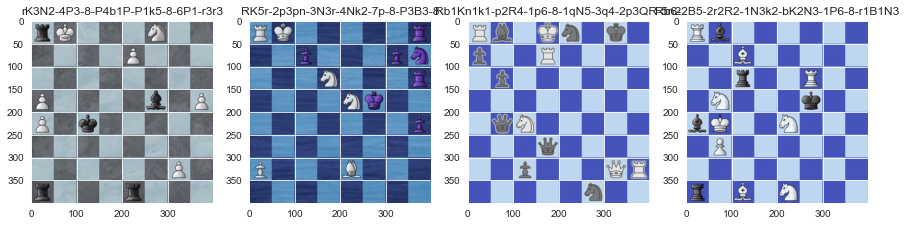

In [498]:
fig, ax = plt.subplots(1,4, figsize=(15,15))
for i in range(4):
    ax[i].set_title(y_train[i])
    ax[i].imshow(X_train[i])

# **Preprocessing**

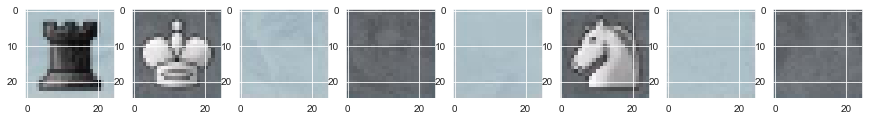

In [499]:
X_test = preprocess(X_test)
X_val = preprocess(X_val)
X_train = preprocess(X_train)

fig, ax = plt.subplots(1,8, figsize=(15,15))
for i in range(8):
    ax[i].imshow(X_train[i])


# **Preprocessing labels*
### label encoder implemetation

In [500]:
le = preprocessing.LabelEncoder()
y_tr = np.array(split_labels(y_train), dtype='str')
y_train_processed = le.fit_transform(y_tr)

print('Encoded classes: ',list(le.classes_))
print('Encoded sample: ',y_train_processed[:7])

save_encoder(le)

y_t = np.array(split_labels(y_test),dtype='str')
y_test_processed = le.transform(y_t)


Encoded classes:  ['1', 'B', 'K', 'N', 'P', 'Q', 'R', 'b', 'k', 'n', 'p', 'q', 'r']
Encoded sample:  [12  2  0  0  0  3  0]


In [501]:
encoded_labels = set(y_train_processed)
encoded_labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [502]:
print("Length of training data: ",len(X_train))
print("Length of training labels: ",len(y_train_processed))

Length of training data:  32000
Length of training labels:  32000


y_test: 6


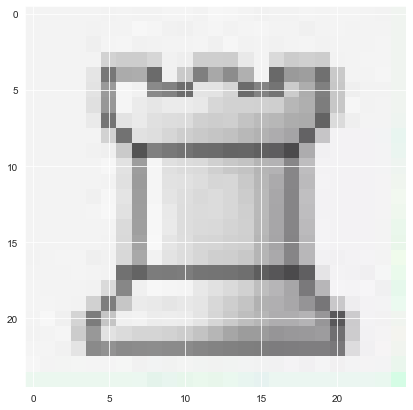

In [503]:
plt.imshow(X_test[0])
print('y_test:',y_test_processed[0])

In [504]:
X_train = (np.array(X_train))
y_train = (np.array(y_train_processed))

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_test = (np.array(X_test))
y_test = (np.array(y_test_processed))

print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (32000, 25, 25, 3)
y_train shape: (32000,)
x_test shape: (12800, 25, 25, 3)
y_test shape: (12800,)


# Visualization of labels


In [505]:
import seaborn as sns


/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

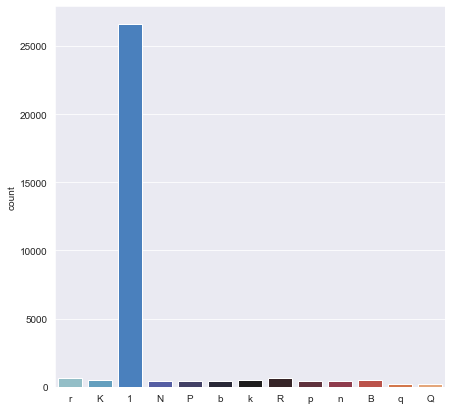

In [506]:
sns.countplot(y_tr, palette = 'icefire')

In [507]:
y_train_df = pd.DataFrame(y_train.reshape(-1,1),columns=['y'])
y_test_df = pd.DataFrame(y_test.reshape(-1,1),columns=['y'])


In [508]:
train_size_x=X_train.shape[0]
train_size_y=X_train.shape[1]*X_train.shape[2]*X_train.shape[3]

test_size_x=X_test.shape[0]
test_size_y=X_train.shape[1]*X_train.shape[2]*X_train.shape[3]

X_train_pca = np.array([])
X_test_pca = np.array([])

X_train_pca = [img.reshape(train_size_y,1) for img in X_train]
X_test_pca = [img.reshape(train_size_y,1) for img in X_test]

x_train_array = np.array(X_train_pca).reshape((train_size_x,train_size_y))
x_test_array = np.array(X_test_pca).reshape((test_size_x,test_size_y))

df_chess_train = pd.DataFrame(x_train_array)
df_chess_test = pd.DataFrame(x_test_array)



In [509]:
X_train = pd.concat([df_chess_train,y_train_df],axis=1)
X_test = pd.concat([df_chess_test,y_test_df],axis=1)



In [510]:
X_train.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1866,1867,1868,1869,1870,1871,1872,1873,1874,y
0,167,186,193,168,187,194,171,189,196,172,...,185,197,201,185,197,201,186,192,197,12
1,99,110,118,99,107,114,103,106,114,106,...,98,106,115,98,109,117,102,113,121,2
2,174,188,195,164,181,190,163,183,191,167,...,180,195,199,175,191,196,178,194,200,0
3,104,111,120,105,108,116,95,97,105,96,...,100,108,117,97,105,114,89,99,107,0
4,180,193,201,174,192,199,169,189,197,164,...,180,192,195,182,190,195,186,191,198,0


In [511]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,1866,1867,1868,1869,1870,1871,1872,1873,1874,y
count,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,146.735156,162.665375,175.689844,148.262937,164.184188,177.261344,148.388219,164.270406,177.316469,148.354938,...,149.797281,165.776250,178.848594,149.537937,165.563719,178.536844,148.024281,163.995250,176.874281,1.098531
std,60.049110,53.082140,53.050024,61.359428,54.213222,54.129134,61.359373,54.086345,54.126317,61.679755,...,61.959530,54.277076,54.046578,62.019106,54.586517,54.395604,60.883727,53.718606,53.540148,2.830218
min,7.000000,27.000000,33.000000,13.000000,34.000000,36.000000,18.000000,37.000000,39.000000,15.000000,...,14.000000,36.000000,38.000000,19.000000,38.000000,36.000000,17.000000,25.000000,28.000000,0.000000
25%,102.000000,124.000000,131.000000,97.000000,122.000000,131.000000,96.000000,123.000000,131.000000,97.000000,...,99.000000,124.000000,131.000000,99.000000,123.000000,130.000000,101.000000,125.000000,131.000000,0.000000
50%,147.000000,163.000000,186.000000,154.000000,164.000000,187.000000,154.000000,163.000000,186.000000,154.000000,...,155.000000,164.000000,188.000000,155.000000,163.000000,189.000000,149.000000,163.000000,187.000000,0.000000
75%,190.000000,213.000000,217.000000,190.000000,215.000000,221.000000,189.000000,215.000000,221.000000,190.000000,...,203.000000,216.000000,222.000000,202.000000,217.000000,222.000000,198.000000,215.000000,220.000000,0.000000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,12.000000


In [512]:
X_train['y'].value_counts()


0     26581
6       666
12      644
2       500
8       500
1       481
4       455
3       449
10      445
7       441
9       438
11      217
5       183
Name: y, dtype: int64

<AxesSubplot:>

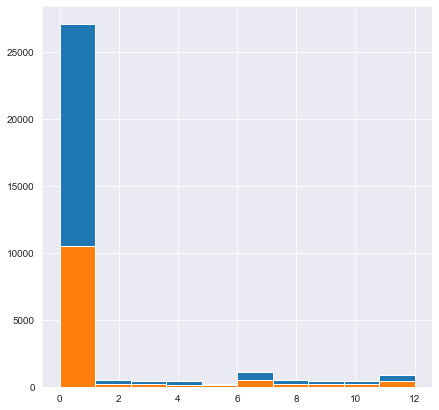

In [513]:
X_train['y'].hist()
X_test['y'].hist()

# Solving data Imbalance using resampling

In [514]:

train_count = resample(X_train,40)
test_count = resample(X_test,40)

print('train_count',train_count,'test_count',test_count)

# labels = [0.0]
for i in encoded_labels:
    # print(i)
    X_train = remove_values(i,train_count,X_train)
    X_test = remove_values(i,test_count,X_test)

train_count 183 test_count 105


/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y', ylabel='count'>

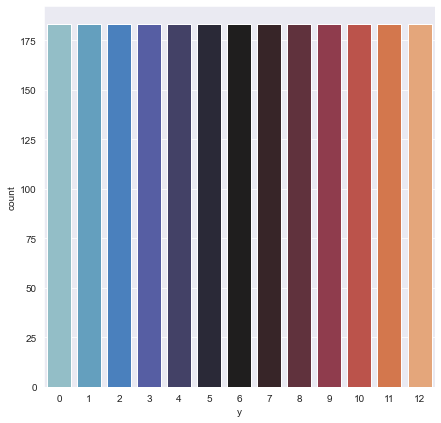

In [515]:
sns.countplot(X_train['y'], palette = 'icefire')

/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y', ylabel='count'>

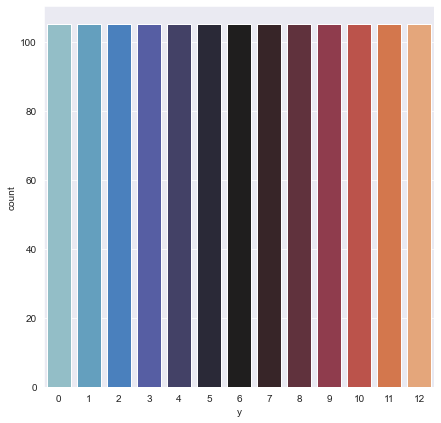

In [516]:
sns.countplot(X_test['y'], palette = 'icefire')

## Split Dataset

In [517]:
train_y = X_train['y']
train_X = X_train.drop(columns=['y'])

test_y = X_test['y']
test_X = X_test.drop(columns=['y'])



In [518]:
train_X.shape

(2379, 1875)

# Normalization

In [519]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True).fit(train_X)
X_train_norm = scaler.transform(train_X)
X_test_norm = scaler.transform(test_X)

In [520]:
X_train_norm.std(), X_test_norm.std()

(0.9999999999999998, 0.9886432446242495)

In [521]:
X_train_pca = X_train_norm
y_train_pca = train_y
X_test_pca = X_test_norm
y_test_pca = test_y


# Visualization using TSNE

In [522]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train_pca)

/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/meghas/opt/miniconda3/envs/actionlearning/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2379 samples in 0.008s...
[t-SNE] Computed neighbors for 2379 samples in 2.715s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2379
[t-SNE] Computed conditional probabilities for sample 2000 / 2379
[t-SNE] Computed conditional probabilities for sample 2379 / 2379
[t-SNE] Mean sigma: 13.202692
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.467422
[t-SNE] KL divergence after 300 iterations: 1.300691


<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

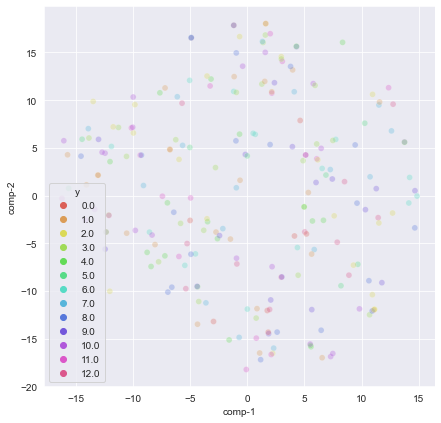

In [523]:
plt.rcParams["figure.figsize"] = (7,7)
tsne_df = pd.DataFrame()

tsne_df["comp-1"] = tsne_results[:,0]
tsne_df["comp-2"] = tsne_results[:,1]

sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=train_y, palette=sns.color_palette("hls", 13), data=tsne_df,
    legend="full", alpha=0.3
)

# **Finding the principle components**

In [524]:
from sklearn.decomposition import PCA
dim_sel = PCA()
df_PCA = dim_sel.fit_transform(X_train_pca)
dim_sel.n_components_

1875

In [525]:
df_PCA.shape

(2379, 1875)

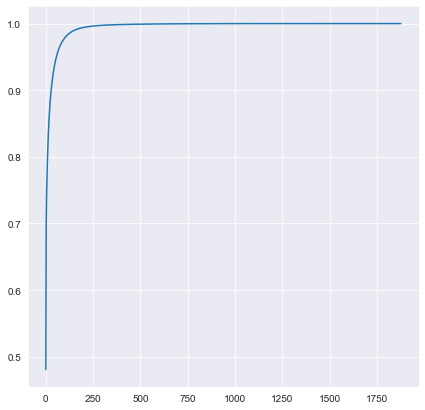

In [526]:
plt.plot(range(1,dim_sel.n_components_+1), dim_sel.explained_variance_ratio_.cumsum());


# Modeling pipeline for prediction

In [527]:
pca = None
svc = None
scaler = None

def pipeline_processing(X_train_, X_test_, y_train_, y_test_, is_train, model=None):
    scaler = StandardScaler(with_mean=True, with_std=True)
    pca = PCA(n_components=150)
    svc = SVC(kernel='rbf', degree=2, decision_function_shape='ovo')
    pipeline = Pipeline([
                         ('scale', scaler),
                         ('pca', pca),
                         ('svm', svc),
    ])

    if is_train:
        pipeline.fit(X_train_, y_train_)
        y_test_pred = pipeline.predict(X_test_)
        acc = accuracy_score(y_test_, y_test_pred)
        save_model(pipeline)
        return y_test_pred, acc, pipeline
    else:
        y_test_pred = model.predict(X_test_)
        return y_test_pred, -1, model

### Testing model predictions with training set


In [528]:
y_pred_pipe, accuracy_pipe, model = pipeline_processing(train_X, test_X, train_y,test_y , True)
accuracy_pipe

0.9663003663003663

### Testing model predictions with test set


In [529]:
y_pred_pipe, accuracy_pipe , model= pipeline_processing([], test_X, [],test_y , False, model)
accuracy_score(y_test_pca, y_pred_pipe)

0.9663003663003663

# **SVM for prediction of fen**

In [530]:

def process_test_img(chess_board_image):
    test_image_ = [img.reshape(1875,1) for img in chess_board_image]
    test_image_ = (np.array(test_image_))

    size_x=test_image_.shape[0]
    size_y=test_image_.shape[1]*test_image_.shape[2]

    test_board_img = [img.reshape(size_y,1) for img in test_image_]
    test_board_array = np.array(test_board_img).reshape((size_x,size_y))
    processed_test_img = pd.DataFrame(test_board_array)

    return processed_test_img


def predict(chess_board_image):
    processed_test_img = process_test_img(chess_board_image)
    model = load_model('models/pipeline_model.pkl')
    prediction = model.predict(processed_test_img)
    fen_predicted = decode_fen(np.array(prediction).reshape(8,8))
    return fen_predicted



# Making prediction

In [531]:
random_index = randint(0,len(val))
test_image,test_img_orginal = prepare_test_image(val[random_index])
prediction  = predict(test_image)
prediction

'r7-8-2P5-2b1bk2-8-K5n1-8-3b1b2'

# Comparison with original chess board

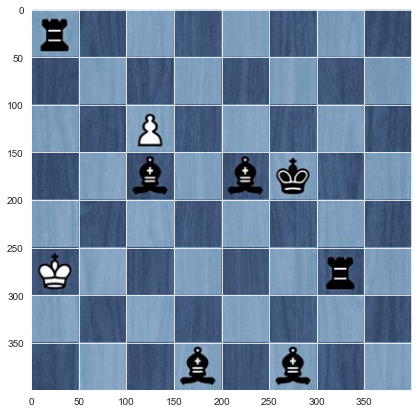

In [532]:
plt.imshow(test_img_orginal)